In [1]:
from shared import get_clean_data

print("Normalizing data (or loaded pre-computed)")
%time edges, num_edges, num_nodes = get_clean_data(shuffle=True)
%time unshuffled_edges, unshuffled_num_edges, unshuffled_num_nodes = get_clean_data(shuffle=False)
print('\nEDGES SHAPE: {}'.format(edges.shape))

Normalizing data (or loaded pre-computed)
Parsing from zip. Will write to file /home/sami/py-graph/LJ-cleaned-shuffled.npy
ORIGINAL DIST: 1342.0403699254255 MIN: 0 MAX: 4038
CPU times: user 183 ms, sys: 11.6 ms, total: 195 ms
Wall time: 195 ms
Parsing from zip. Will write to file /home/sami/py-graph/LJ-cleaned.npy
ORIGINAL DIST: 289.4173561212231 MIN: 0 MAX: 4038
CPU times: user 157 ms, sys: 3.81 ms, total: 160 ms
Wall time: 160 ms

EDGES SHAPE: (176468, 2)


In [2]:
%load_ext Cython
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
%%cython
import numpy as np

cdef int UNMAPPED = -1

def fennel(int[:,::] edges,
           int num_nodes,
           int num_partitions,
           int[::] partition,
           float alpha):
    """
    This algorithm favors a cluster if it has many neighbors of a node, but
    penalizes the cluster if it is close to capacity.
    
    partition: A previous partition of the nodes. Set to -1's if a node has not been assigned.
    """
    
    cdef int[::] partition_sizes = None
    # The output partition
    if partition is None:
        partition = np.repeat(np.int32(UNMAPPED), num_nodes)
        partition_sizes = np.zeros(num_partitions, dtype=np.int32)
    else:
        partition_sizes = np.bincount(partition).astype(np.int32)
    
    cdef int[::] partition_votes = np.zeros(num_partitions, dtype=np.int32)
    
    cdef float partition_capacity = num_nodes / num_partitions
    
    cdef int last_left = edges[0,0]
    cdef int i = 0
    cdef int left = 0
    cdef int right = 0
    cdef int arg = 0
    cdef int max_arg = 0
    cdef float max_val = 0
    cdef float val = 0
    cdef int len_edges = len(edges)
    cdef int previous_assignment = 0

    for i in range(len_edges):
        left = edges[i,0]
        right = edges[i,1]
    
        if last_left != left:
            # New left node, so we have to assign last left

            # Remember placement of last_left in the previous assignment
            previous_assignment = partition[last_left]
            
            max_arg = 0
            max_val = partition_votes[0] - alpha * partition_sizes[0]
            if previous_assignment == 0:
                # We remove the node from its current partition before
                # deciding to re-add it, so subtract alpha to give
                # result of 1 lower partition size.
                max_val += alpha

            for arg in range(1, num_partitions):
                val = partition_votes[arg] - alpha * partition_sizes[arg]
                if previous_assignment == arg:
                    # See comment above
                    val += alpha
                if val > max_val:
                    max_arg = arg
                    max_val = val

            if max_arg != previous_assignment:
                partition[last_left] = max_arg
                partition_sizes[max_arg] += 1
                if previous_assignment != UNMAPPED:
                    partition_sizes[previous_assignment] -= 1

            partition_votes[:] = 0
            last_left = left

        if partition[right] != -1:
            partition_votes[partition[right]] += 1
    
    # TODO: finish off this fencepost....
    partition[left] = 0
    
    return np.asarray(partition)

In [4]:
def draw_figures(waste_values, edge_score_values, num_partitions):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    (waste_axes, score_axes) = axes
    waste_axes.plot(waste_values, 'r')
    waste_axes.set_xlabel('Round')
    waste_axes.set_ylabel('Number of wasted bins')
    waste_axes.set_ylim(bottom=0)
    waste_axes.set_title('Wasted Bins: {} partitions'.format(num_partitions))
    
    score_axes.plot(edge_score_values, 'r')
    score_axes.set_xlabel('Round')
    score_axes.set_ylabel('Ratio of edges crossing partitions')
    score_axes.set_ylim(bottom=0)
    score_axes.set_title('Score: {} partitions'.format(num_partitions))
    
    fig.tight_layout()

In [5]:
from shared import score

def run_fennel_restreaming(edges, num_nodes, num_partitions, num_iterations):
    print('{} PARTITIONS'.format(num_partitions))
    assignments = None
    # We will explore this parameter in a future post. This is sub-optimal
    alphas = np.linspace(1.251608191745264e-07, 7.588951557309824e-05, num_iterations)
    waste_scores, edge_score_values = [], []
    print('ROUND\tALPHA\tWASTE\tSCORE\tCUT')
    for i in range(num_iterations):
        alpha = alphas[i]
        assignments = fennel(edges, num_nodes, num_partitions, assignments, alpha)
        (waste, edge_score, cut) = score(assignments, edges)
        print('{}\t{:.1e}\t{:0.3f}\t{:0.3f}\t{}'.format(i, alpha, waste, edge_score, cut))
        waste_scores.append(waste)
        edge_score_values.append(edge_score)
    draw_figures(waste_scores, edge_score_values, num_partitions)

4 PARTITIONS
ROUND	ALPHA	WASTE	SCORE	CUT
0	1.3e-07	0.123	0.096	16916
1	5.5e-06	0.299	0.057	9998
2	1.1e-05	0.321	0.053	9436
3	1.6e-05	0.325	0.052	9226
4	2.2e-05	0.330	0.052	9120
5	2.7e-05	0.332	0.052	9108
6	3.3e-05	0.332	0.052	9108
7	3.8e-05	0.332	0.052	9108
8	4.3e-05	0.332	0.052	9108
9	4.9e-05	0.332	0.052	9108
10	5.4e-05	0.332	0.052	9108
11	6.0e-05	0.332	0.052	9108
12	6.5e-05	0.332	0.052	9108
13	7.0e-05	0.332	0.052	9108
14	7.6e-05	0.332	0.052	9108
CPU times: user 183 ms, sys: 0 ns, total: 183 ms
Wall time: 183 ms


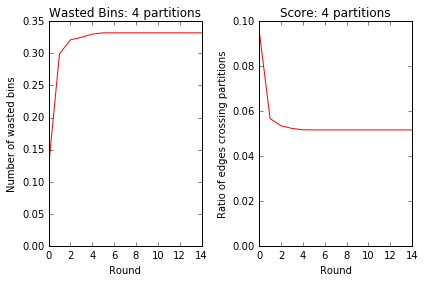

In [6]:
%time run_fennel_restreaming(edges, num_nodes, 4, 15)

20 PARTITIONS
ROUND	ALPHA	WASTE	SCORE	CUT
0	1.3e-07	1.352	0.168	29728
1	5.5e-06	1.857	0.089	15770
2	1.1e-05	1.941	0.075	13296
3	1.6e-05	1.956	0.072	12762
4	2.2e-05	1.956	0.072	12716
5	2.7e-05	1.956	0.072	12716
6	3.3e-05	1.956	0.072	12716
7	3.8e-05	1.956	0.072	12716
8	4.3e-05	1.956	0.072	12716
9	4.9e-05	1.956	0.072	12716
10	5.4e-05	1.956	0.072	12716
11	6.0e-05	1.956	0.072	12716
12	6.5e-05	1.956	0.072	12716
13	7.0e-05	1.956	0.072	12716
14	7.6e-05	1.956	0.072	12716
CPU times: user 174 ms, sys: 0 ns, total: 174 ms
Wall time: 173 ms


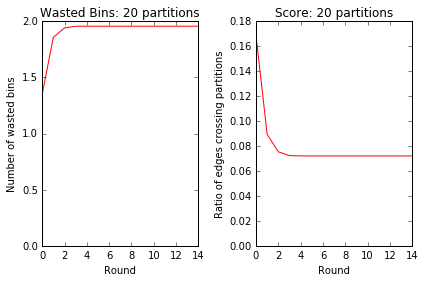

In [7]:
%time run_fennel_restreaming(edges, num_nodes, 20, 15)